# Machine Learning Model

In [13]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
import numpy as np
import seaborn as sn
import pickle
import matplotlib.pyplot as plt

In [2]:
final_data = pd.read_csv("join.csv")

In [3]:
final_data.head()

,Country,Year,Item,Average Rainfall (mm/year),Pesticides (Tonnes),Average Temperature,Yield (hg/ha)
0,Albania,1990,Maize,1485,121.0,16.37,36613
1,Albania,1990,Potatoes,1485,121.0,16.37,66667
2,Albania,1990,"Rice, paddy",1485,121.0,16.37,23333
3,Albania,1990,Sorghum,1485,121.0,16.37,12500
4,Albania,1990,Soybeans,1485,121.0,16.37,7000


#### We are going to one Hot encode our country column. And for that, we are going to do a count of all the observations by country names. For countries who do not fall in top 15, we are going to change their name to "Other". We are doing this as we do not want too many variables in our model as this will overfit our model.

In [4]:
country_count = dict(final_data.Country.value_counts())
country_count

{'Kenya': 230,
 'Democratic Republic of the Congo': 230,
 'Venezuela': 230,
 'Cameroon': 230,
 'Tanzania': 230,
 'Bolivia': 207,
 'Mali': 207,
 'Peru': 207,
 'Ecuador': 207,
 'Colombia': 207,
 'Burundi': 207,
 'Brazil': 207,
 'Rwanda': 207,
 'Uganda': 207,
 'Guatemala': 204,
 'Honduras': 204,
 'Zimbabwe': 184,
 'Argentina': 184,
 'Haiti': 184,
 'El Salvador': 184,
 'Zambia': 184,
 'Dominican Republic': 184,
 'Madagascar': 184,
 'India': 184,
 "Côte d'Ivoire": 184,
 'Mexico': 184,
 'China': 184,
 'Sri Lanka': 184,
 'Burkina Faso': 184,
 'Nicaragua': 183,
 'Malawi': 171,
 'Guinea': 171,
 'Angola': 164,
 'Morocco': 161,
 'Mozambique': 161,
 'Mauritania': 161,
 'Italy': 161,
 'Jamaica': 161,
 'Japan': 161,
 'Niger': 161,
 'Thailand': 161,
 'Greece': 161,
 'South Africa': 161,
 'United States of America': 161,
 'Uruguay': 161,
 'Central African Republic': 161,
 'Spain': 161,
 'Australia': 161,
 'Egypt': 161,
 'Papua New Guinea': 161,
 'Pakistan': 161,
 'Ghana': 155,
 'Bangladesh': 147,
 'Se

In [5]:
def country_modifier(x, val_counts):
    """Modify a Country."""
    if val_counts[x] >= 200:
        return x
    else:
        return "Other"

final_data["Country_New"] = final_data["Country"].apply(
    country_modifier, val_counts=country_count
)

In [6]:
features_data = final_data[
    [
        "Country_New",
        "Average Rainfall (mm/year)",
        "Pesticides (Tonnes)",
        "Average Temperature",
        "Item",
    ]
]
response = final_data["Yield (hg/ha)"]

In [7]:
correlation_df = features_data[[ "Average Rainfall (mm/year)",
        "Pesticides (Tonnes)",
        "Average Temperature",]]

CorrMatrix = correlation_df.corr()
CorrMatrix

,Average Rainfall (mm/year),Pesticides (Tonnes),Average Temperature
Average Rainfall (mm/year),1.000000,-0.073277,0.390169
Pesticides (Tonnes),-0.073277,1.000000,-0.129931
Average Temperature,0.390169,-0.129931,1.000000


#### From the correlation matrix, we can clearly see that no two independent variables are highly correlated. If any two variables were highly correlated, it would be hard to interpret the results of regression and we would have to eliminate one of the variables. 

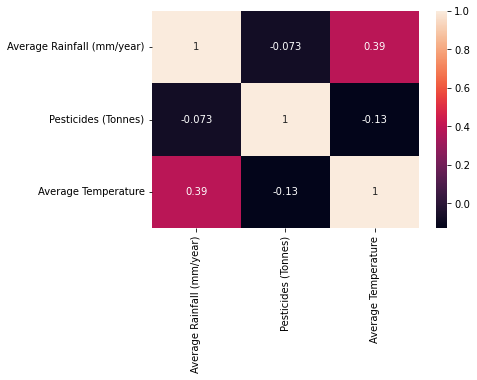

In [8]:
sn.heatmap(CorrMatrix, annot=True)
plt.show()

#### At the very start, we are splitting our model into trainind data and testing data. The 20% test data will be used at the very end when we are sure which machine learning model to use and with what hyperparameters. 

In [9]:
# main test split
X_train, X_test, y_train, y_test = train_test_split(
    features_data,
    response,
    test_size=0.2,
    random_state=42,
    stratify=features_data[["Country_New", "Item"]],
)

In [10]:
categorical_data = X_train[["Country_New", "Item"]]
numerical_data = X_train[
    ["Average Rainfall (mm/year)", "Pesticides (Tonnes)", "Average Temperature"]
]

####  We have two categorical variables and four numerical variables. Categorical variables will be encoded while the numerical variables will be standardized. We are performing one hot encoidng becasue machine learning algorithms do not take numerical values. And we are standartdizing numerical data because on variables are at a different scale.  

In [11]:
# One hot encoding data
ohe = OneHotEncoder(handle_unknown="error")
ohe.fit(categorical_data)
ohe_data = ohe.transform(categorical_data).toarray()

In [12]:
ohe.get_feature_names()




array(['x0_Bolivia', 'x0_Brazil', 'x0_Burundi', 'x0_Cameroon',
       'x0_Colombia', 'x0_Democratic Republic of the Congo', 'x0_Ecuador',
       'x0_Guatemala', 'x0_Honduras', 'x0_Kenya', 'x0_Mali', 'x0_Other',
       'x0_Peru', 'x0_Rwanda', 'x0_Tanzania', 'x0_Uganda', 'x0_Venezuela',
       'x1_Cassava', 'x1_Maize', 'x1_Plantains and others', 'x1_Potatoes',
       'x1_Rice, paddy', 'x1_Sorghum', 'x1_Soybeans', 'x1_Sweet potatoes',
       'x1_Wheat', 'x1_Yams'], dtype=object)

In [14]:
#Standarzizing data
std = StandardScaler()
std.fit(numerical_data)
num_data = std.transform(numerical_data)

In [15]:
x_train = np.hstack((num_data, ohe_data))

#### The reamining training data will be further split into training new and validation data. On validation data, we will tune our hyperparamters for all models and see which model gives us the best results. 

In [16]:
# validation split
X_train_new, X_val, y_train_new, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

#### Now we are going to apply six different models and see which models gives us the best r2 score.

In [17]:
LR_model = LinearRegression()
LR_model.fit(X_train_new, y_train_new)
y_pred = LR_model.predict(X_val)
LR_model_r2 = r2_score(y_val, y_pred)
LR_model_r2

0.5802138651840216

In [42]:
RF_model = RandomForestRegressor()
RF_model.fit(X_train_new, y_train_new)
y_pred = RF_model.predict(X_val)
RF_model_r2 = r2_score(y_val, y_pred)
RF_model_r2

0.9353962595227512

In [19]:
GBM_model = GradientBoostingRegressor(n_estimators=600)
GBM_model.fit(X_train_new, y_train_new)
y_pred = GBM_model.predict(X_val)
GBM_model_r2 = r2_score(y_val, y_pred)
GBM_model_r2

0.881741073206818

In [20]:
MLP_model = MLPRegressor(max_iter=200)
MLP_model.fit(X_train_new, y_train_new)
y_pred = MLP_model.predict(X_val)
MLP_model_r2 = r2_score(y_val, y_pred)
MLP_model_r2

C:\Users\bilal\anaconda3\envs\mlenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


-0.1939249582236866

In [21]:
DTR_model = DecisionTreeRegressor()
DTR_model.fit(X_train_new, y_train_new)
y_pred = DTR_model.predict(X_val)
DTR_model_r2 = r2_score(y_val, y_pred)
DTR_model_r2

0.8940136958290817

In [22]:
Lasso_model = linear_model.Lasso(alpha=0.1,max_iter=50000)
Lasso_model.fit(X_train_new, y_train_new)
y_pred = Lasso_model.predict(X_val)
Lasso_model_r2 = r2_score(y_val, y_pred)
Lasso_model_r2

0.5802107811373132

#### After using multiple models and adjusting their parameters, we found out that RandomForestRegressor() gave the best result. Now we are going to apply the Grid Search tenchnique in order to find the best possible parameters for our model. We are going to fit this to our training data which we set aside at the very beginning. 

In [43]:
# Define the model

RF_model = RandomForestRegressor()

# Define the grid

param_grid = {
'n_estimators': [50, 100, 200, 300],
'min_samples_leaf': [1, 5, 10],
'max_depth': [2, 4, 6, 8, 10],
'max_features': ['auto', 'sqrt'],
'bootstrap': [True, False]}

# Instantiate GridSearchCV

model_gridsearch = GridSearchCV(
estimator=RF_model,
param_grid=param_grid,
scoring='r2',
n_jobs=-1,
cv=2,
refit=True,
return_train_score=True)

In [44]:
model_gridsearch.fit(x_train, y_train)

GridSearchCV(cv=2, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [2, 4, 6, 8, 10],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 5, 10],
                         'n_estimators': [50, 100, 200, 300]},
             return_train_score=True, scoring='r2')

In [45]:
print(model_gridsearch.best_estimator_)


RandomForestRegressor(max_depth=10, n_estimators=200)


#### So from the grid search technique, we find out that in the RandomForestRegressor model, max_depth =10 and n_estimators=200 will give us the best possible model. It did not return other parameters which we passed in our param_grid dictionary as those parameters will not significantly affect our result. 

In [46]:
final_RF_model = RandomForestRegressor(max_depth=10, n_estimators=200)
final_RF_model.fit(x_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=200)

In [47]:
categorical_test_data = X_test[["Country_New", "Item"]]
numerical_test_data = X_test[
    ["Average Rainfall (mm/year)", "Pesticides (Tonnes)", "Average Temperature"]
]

#### Finally, we our going to incorporate the test data we set aside at the very start. Test data will also be one hot encoded and standardized just like we did with the training data. 

In [48]:
# One hot encoder
ohe = OneHotEncoder(handle_unknown="error")
ohe.fit(categorical_data)
ohe_test_data = ohe.transform(categorical_test_data).toarray()

#Standarzizing data
std = StandardScaler()
std.fit(numerical_data)
num_test_data = std.transform(numerical_test_data)

In [49]:
test = np.hstack((num_test_data, ohe_test_data))

In [51]:
y_prediction = final_RF_model.predict(test)

#### The r2 score which we get from using y_test and test_prediction is very similar to the score we got previously. 

In [52]:
print(r2_score(y_test,y_prediction))

0.9137246390183409
